In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISBI-resized/train/'
validation_dir = 'data-ISBI-resized/validation/'
test_dir = 'data-ISBI-resized/test/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_MobileNet_Concatenate3_ImageNetMean"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISBI-resized/train/ 0
data-ISBI-resized/train/malignant 40425
data-ISBI-resized/train/normal 18747
******************************
data-ISBI-resized/test/ 0
data-ISBI-resized/test/malignant 655
data-ISBI-resized/test/normal 312


In [5]:
batch_size = 32
img_height, img_width = 380, 380
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [6]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=False,
    featurewise_std_normalization=False,
#     validation_split= 0.25,
    preprocessing_function = preprocess_input,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59170
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1850
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [9]:
basemodel1=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x1=basemodel1.get_layer('block5_pool').output
x1=GlobalAveragePooling2D()(x1)

basemodel2=MobileNet(weights=None,input_tensor = basemodel1.input, include_top=False, input_shape=input_shape)
x2 = basemodel2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
merge = Dropout(0.6)(merge)
preds = Dense(num_classes, activation='relu')(merge)
model = Model(inputs=basemodel1.input,outputs=preds)

In [10]:
# bottleneck_final_model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [11]:
c1 = model.layers[74].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[80].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[88].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[96].output
c4 = GlobalAveragePooling2D()(c4)

c5 = model.layers[103].output
c5 = GlobalAveragePooling2D()(c5)


con = concatenate([c1,c2,c3,c4,c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [12]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [13]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [14]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [15]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

adam_opt=Adam(lr = 0.001, beta_1=0.7, beta_2=0.999, amsgrad=True)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59170 samples, validate on 18384 samples
Epoch 1/1000
 - 8s - loss: 0.5053 - acc: 0.7700 - val_loss: 0.4859 - val_acc: 0.7848
Epoch 2/1000
 - 7s - loss: 0.4832 - acc: 0.7847 - val_loss: 0.4725 - val_acc: 0.7916
Epoch 3/1000
 - 7s - loss: 0.4741 - acc: 0.7900 - val_loss: 0.4645 - val_acc: 0.7986
Epoch 4/1000
 - 7s - loss: 0.4663 - acc: 0.7953 - val_loss: 0.4558 - val_acc: 0.8029
Epoch 5/1000
 - 7s - loss: 0.4604 - acc: 0.7978 - val_loss: 0.4665 - val_acc: 0.7961
Epoch 6/1000
 - 7s - loss: 0.4550 - acc: 0.7999 - val_loss: 0.4553 - val_acc: 0.8010
Epoch 7/1000
 - 7s - loss: 0.4513 - acc: 0.8010 - val_loss: 0.4462 - val_acc: 0.8070
Epoch 8/1000
 - 7s - loss: 0.4475 - acc: 0.8042 - val_loss: 0.4657 - val_acc: 0.7963
Epoch 9/1000
 - 7s - loss: 0.4463 - acc: 0.8039 - val_loss: 0.4397 - val_acc: 0.8126
Epoch 10/1000
 - 7s - loss: 0.4438 - acc: 0.8054 - val_loss: 0.4431 - val_acc: 0.8128
Epoch 11/1000
 - 7s - loss: 0.4401 - acc: 0.8085 - val_loss: 0.4370 - val_acc: 0.8153
Epoch 12/1000

Epoch 96/1000
 - 7s - loss: 0.3820 - acc: 0.8398 - val_loss: 0.4044 - val_acc: 0.8320
Epoch 97/1000
 - 7s - loss: 0.3830 - acc: 0.8390 - val_loss: 0.4086 - val_acc: 0.8327
Epoch 98/1000
 - 7s - loss: 0.3825 - acc: 0.8392 - val_loss: 0.4103 - val_acc: 0.8326
Epoch 99/1000
 - 7s - loss: 0.3816 - acc: 0.8381 - val_loss: 0.4109 - val_acc: 0.8279
Epoch 100/1000
 - 7s - loss: 0.3789 - acc: 0.8401 - val_loss: 0.4001 - val_acc: 0.8352
Epoch 101/1000
 - 7s - loss: 0.3818 - acc: 0.8385 - val_loss: 0.4164 - val_acc: 0.8291
Epoch 102/1000
 - 7s - loss: 0.3800 - acc: 0.8396 - val_loss: 0.4077 - val_acc: 0.8303
Epoch 103/1000
 - 7s - loss: 0.3801 - acc: 0.8402 - val_loss: 0.4083 - val_acc: 0.8285
Epoch 104/1000
 - 7s - loss: 0.3793 - acc: 0.8400 - val_loss: 0.4219 - val_acc: 0.8277
Epoch 105/1000
 - 7s - loss: 0.3792 - acc: 0.8393 - val_loss: 0.4067 - val_acc: 0.8331
Epoch 106/1000
 - 7s - loss: 0.3789 - acc: 0.8426 - val_loss: 0.4098 - val_acc: 0.8272
Epoch 107/1000
 - 7s - loss: 0.3773 - acc: 0.84

Epoch 191/1000
 - 7s - loss: 0.3555 - acc: 0.8517 - val_loss: 0.4189 - val_acc: 0.8305
Epoch 192/1000
 - 7s - loss: 0.3554 - acc: 0.8506 - val_loss: 0.4205 - val_acc: 0.8263
Epoch 193/1000
 - 7s - loss: 0.3558 - acc: 0.8518 - val_loss: 0.4060 - val_acc: 0.8331
Epoch 194/1000
 - 7s - loss: 0.3529 - acc: 0.8529 - val_loss: 0.4031 - val_acc: 0.8326
Epoch 195/1000
 - 7s - loss: 0.3563 - acc: 0.8515 - val_loss: 0.4061 - val_acc: 0.8331
Epoch 196/1000
 - 7s - loss: 0.3566 - acc: 0.8500 - val_loss: 0.4201 - val_acc: 0.8299
Epoch 197/1000
 - 7s - loss: 0.3544 - acc: 0.8522 - val_loss: 0.4099 - val_acc: 0.8315
Epoch 198/1000
 - 7s - loss: 0.3528 - acc: 0.8527 - val_loss: 0.4126 - val_acc: 0.8297
Epoch 199/1000
 - 7s - loss: 0.3529 - acc: 0.8525 - val_loss: 0.4233 - val_acc: 0.8204
Epoch 200/1000
 - 7s - loss: 0.3637 - acc: 0.8460 - val_loss: 0.4166 - val_acc: 0.8287
Epoch 201/1000
 - 7s - loss: 0.3585 - acc: 0.8491 - val_loss: 0.4434 - val_acc: 0.8108
Epoch 202/1000
 - 7s - loss: 0.3590 - acc: 

 - 7s - loss: 0.3377 - acc: 0.8583 - val_loss: 0.4638 - val_acc: 0.8036
Epoch 286/1000
 - 7s - loss: 0.3455 - acc: 0.8530 - val_loss: 0.4010 - val_acc: 0.8373
Epoch 287/1000
 - 7s - loss: 0.3438 - acc: 0.8549 - val_loss: 0.4179 - val_acc: 0.8352
Epoch 288/1000
 - 7s - loss: 0.3424 - acc: 0.8546 - val_loss: 0.4074 - val_acc: 0.8350
Epoch 289/1000
 - 7s - loss: 0.3399 - acc: 0.8571 - val_loss: 0.4266 - val_acc: 0.8270
Epoch 290/1000
 - 7s - loss: 0.3379 - acc: 0.8573 - val_loss: 0.4664 - val_acc: 0.8127
Epoch 291/1000
 - 7s - loss: 0.3511 - acc: 0.8510 - val_loss: 0.4341 - val_acc: 0.8235
Epoch 292/1000
 - 7s - loss: 0.3532 - acc: 0.8485 - val_loss: 0.4237 - val_acc: 0.8335
Epoch 293/1000
 - 7s - loss: 0.3452 - acc: 0.8538 - val_loss: 0.4161 - val_acc: 0.8371
Epoch 294/1000
 - 7s - loss: 0.3446 - acc: 0.8551 - val_loss: 0.4114 - val_acc: 0.8356
Epoch 295/1000
 - 7s - loss: 0.3431 - acc: 0.8551 - val_loss: 0.4081 - val_acc: 0.8314
Epoch 296/1000
 - 7s - loss: 0.3411 - acc: 0.8564 - val_lo

Epoch 380/1000
 - 7s - loss: 0.3211 - acc: 0.8644 - val_loss: 0.4624 - val_acc: 0.8157
Epoch 381/1000
 - 7s - loss: 0.3258 - acc: 0.8629 - val_loss: 0.4192 - val_acc: 0.8351
Epoch 382/1000
 - 7s - loss: 0.3237 - acc: 0.8648 - val_loss: 0.4748 - val_acc: 0.8114
Epoch 383/1000
 - 7s - loss: 0.3198 - acc: 0.8664 - val_loss: 0.4322 - val_acc: 0.8257
Epoch 384/1000
 - 7s - loss: 0.3216 - acc: 0.8660 - val_loss: 0.4260 - val_acc: 0.8328
Epoch 385/1000
 - 7s - loss: 0.3215 - acc: 0.8658 - val_loss: 0.4128 - val_acc: 0.8351
Epoch 386/1000
 - 7s - loss: 0.3206 - acc: 0.8657 - val_loss: 0.4360 - val_acc: 0.8273
Epoch 387/1000
 - 7s - loss: 0.3188 - acc: 0.8662 - val_loss: 0.4451 - val_acc: 0.8308
Epoch 388/1000
 - 7s - loss: 0.3185 - acc: 0.8680 - val_loss: 0.4367 - val_acc: 0.8297
Epoch 389/1000
 - 7s - loss: 0.3209 - acc: 0.8658 - val_loss: 0.4177 - val_acc: 0.8345
Epoch 390/1000
 - 7s - loss: 0.3246 - acc: 0.8631 - val_loss: 0.4267 - val_acc: 0.8314
Epoch 391/1000
 - 7s - loss: 0.3260 - acc: 

 - 7s - loss: 0.3086 - acc: 0.8702 - val_loss: 0.4623 - val_acc: 0.8277
Epoch 475/1000
 - 7s - loss: 0.3085 - acc: 0.8704 - val_loss: 0.4379 - val_acc: 0.8321
Epoch 476/1000
 - 7s - loss: 0.3048 - acc: 0.8720 - val_loss: 0.4328 - val_acc: 0.8352
Epoch 477/1000
 - 7s - loss: 0.3107 - acc: 0.8702 - val_loss: 0.4410 - val_acc: 0.8322
Epoch 478/1000
 - 7s - loss: 0.3083 - acc: 0.8703 - val_loss: 0.4435 - val_acc: 0.8340
Epoch 479/1000
 - 7s - loss: 0.3097 - acc: 0.8698 - val_loss: 0.4458 - val_acc: 0.8355
Epoch 480/1000
 - 7s - loss: 0.3109 - acc: 0.8702 - val_loss: 0.4277 - val_acc: 0.8330
Epoch 481/1000
 - 7s - loss: 0.3147 - acc: 0.8678 - val_loss: 0.4487 - val_acc: 0.8311
Epoch 482/1000
 - 7s - loss: 0.3123 - acc: 0.8690 - val_loss: 0.4488 - val_acc: 0.8276
Epoch 483/1000
 - 7s - loss: 0.3140 - acc: 0.8684 - val_loss: 0.4349 - val_acc: 0.8301
Epoch 484/1000
 - 7s - loss: 0.3110 - acc: 0.8700 - val_loss: 0.4394 - val_acc: 0.8343
Epoch 485/1000
 - 7s - loss: 0.3096 - acc: 0.8708 - val_lo

Epoch 569/1000
 - 7s - loss: 0.3117 - acc: 0.8666 - val_loss: 0.4582 - val_acc: 0.8315
Epoch 570/1000
 - 7s - loss: 0.3070 - acc: 0.8693 - val_loss: 0.4412 - val_acc: 0.8302
Epoch 571/1000
 - 7s - loss: 0.3056 - acc: 0.8710 - val_loss: 0.4514 - val_acc: 0.8273
Epoch 572/1000
 - 7s - loss: 0.3056 - acc: 0.8706 - val_loss: 0.4414 - val_acc: 0.8333
Epoch 573/1000
 - 7s - loss: 0.3049 - acc: 0.8712 - val_loss: 0.4469 - val_acc: 0.8369
Epoch 574/1000
 - 7s - loss: 0.3094 - acc: 0.8692 - val_loss: 0.4415 - val_acc: 0.8326
Epoch 575/1000
 - 7s - loss: 0.3072 - acc: 0.8693 - val_loss: 0.4854 - val_acc: 0.8348
Epoch 576/1000
 - 7s - loss: 0.3064 - acc: 0.8699 - val_loss: 0.4375 - val_acc: 0.8371
Epoch 577/1000
 - 7s - loss: 0.3061 - acc: 0.8701 - val_loss: 0.4598 - val_acc: 0.8265
Epoch 578/1000
 - 7s - loss: 0.3019 - acc: 0.8737 - val_loss: 0.4398 - val_acc: 0.8353
Epoch 579/1000
 - 7s - loss: 0.3011 - acc: 0.8743 - val_loss: 0.4452 - val_acc: 0.8331
Epoch 580/1000
 - 7s - loss: 0.2993 - acc: 

 - 7s - loss: 0.3142 - acc: 0.8635 - val_loss: 0.4585 - val_acc: 0.8312
Epoch 664/1000
 - 7s - loss: 0.3080 - acc: 0.8688 - val_loss: 0.4757 - val_acc: 0.8258
Epoch 665/1000
 - 7s - loss: 0.3124 - acc: 0.8643 - val_loss: 0.4485 - val_acc: 0.8322
Epoch 666/1000
 - 7s - loss: 0.3093 - acc: 0.8686 - val_loss: 0.4469 - val_acc: 0.8349
Epoch 667/1000
 - 7s - loss: 0.3089 - acc: 0.8689 - val_loss: 0.4571 - val_acc: 0.8321
Epoch 668/1000
 - 7s - loss: 0.3088 - acc: 0.8674 - val_loss: 0.4505 - val_acc: 0.8328
Epoch 669/1000
 - 7s - loss: 0.3092 - acc: 0.8676 - val_loss: 0.4490 - val_acc: 0.8315
Epoch 670/1000
 - 7s - loss: 0.3070 - acc: 0.8691 - val_loss: 0.4740 - val_acc: 0.8295
Epoch 671/1000
 - 7s - loss: 0.3044 - acc: 0.8700 - val_loss: 0.4850 - val_acc: 0.8163
Epoch 672/1000
 - 7s - loss: 0.3029 - acc: 0.8716 - val_loss: 0.4516 - val_acc: 0.8258
Epoch 673/1000
 - 7s - loss: 0.3059 - acc: 0.8693 - val_loss: 0.4665 - val_acc: 0.8247
Epoch 674/1000
 - 7s - loss: 0.3039 - acc: 0.8708 - val_lo

Epoch 758/1000
 - 7s - loss: 0.2977 - acc: 0.8714 - val_loss: 0.4755 - val_acc: 0.8331
Epoch 759/1000
 - 7s - loss: 0.2944 - acc: 0.8736 - val_loss: 0.4726 - val_acc: 0.8316
Epoch 760/1000
 - 7s - loss: 0.2932 - acc: 0.8736 - val_loss: 0.6511 - val_acc: 0.7562
Epoch 761/1000
 - 7s - loss: 0.3014 - acc: 0.8717 - val_loss: 0.4676 - val_acc: 0.8322
Epoch 762/1000
 - 7s - loss: 0.2972 - acc: 0.8733 - val_loss: 0.5012 - val_acc: 0.8233
Epoch 763/1000
 - 7s - loss: 0.3000 - acc: 0.8714 - val_loss: 0.4697 - val_acc: 0.8323
Epoch 764/1000
 - 7s - loss: 0.2972 - acc: 0.8721 - val_loss: 0.4617 - val_acc: 0.8335
Epoch 765/1000
 - 7s - loss: 0.2979 - acc: 0.8728 - val_loss: 0.4762 - val_acc: 0.8196
Epoch 766/1000
 - 7s - loss: 0.3077 - acc: 0.8706 - val_loss: 0.4693 - val_acc: 0.8326
Epoch 767/1000
 - 7s - loss: 0.3026 - acc: 0.8703 - val_loss: 0.4501 - val_acc: 0.8299
Epoch 768/1000
 - 7s - loss: 0.3007 - acc: 0.8720 - val_loss: 0.4606 - val_acc: 0.8246
Epoch 769/1000
 - 7s - loss: 0.3008 - acc: 

 - 7s - loss: 0.3028 - acc: 0.8697 - val_loss: 0.4973 - val_acc: 0.8270
Epoch 853/1000
 - 7s - loss: 0.3052 - acc: 0.8704 - val_loss: 0.5159 - val_acc: 0.8121
Epoch 854/1000
 - 7s - loss: 0.3157 - acc: 0.8609 - val_loss: 0.4835 - val_acc: 0.8237
Epoch 855/1000
 - 7s - loss: 0.3062 - acc: 0.8684 - val_loss: 0.4887 - val_acc: 0.8149
Epoch 856/1000
 - 7s - loss: 0.3024 - acc: 0.8692 - val_loss: 0.4859 - val_acc: 0.8252
Epoch 857/1000
 - 7s - loss: 0.3008 - acc: 0.8717 - val_loss: 0.4900 - val_acc: 0.8302
Epoch 858/1000
 - 7s - loss: 0.2976 - acc: 0.8727 - val_loss: 0.4623 - val_acc: 0.8327
Epoch 859/1000
 - 7s - loss: 0.2974 - acc: 0.8717 - val_loss: 0.4692 - val_acc: 0.8306
Epoch 860/1000
 - 7s - loss: 0.2963 - acc: 0.8719 - val_loss: 0.4951 - val_acc: 0.8256
Epoch 861/1000
 - 7s - loss: 0.2982 - acc: 0.8719 - val_loss: 0.5449 - val_acc: 0.8003
Epoch 862/1000
 - 7s - loss: 0.3017 - acc: 0.8728 - val_loss: 0.4760 - val_acc: 0.8296
Epoch 863/1000
 - 7s - loss: 0.3038 - acc: 0.8709 - val_lo

Epoch 947/1000
 - 7s - loss: 0.2858 - acc: 0.8744 - val_loss: 0.5138 - val_acc: 0.8226
Epoch 948/1000
 - 7s - loss: 0.2863 - acc: 0.8768 - val_loss: 0.4799 - val_acc: 0.8338
Epoch 949/1000
 - 7s - loss: 0.2860 - acc: 0.8754 - val_loss: 0.4813 - val_acc: 0.8359
Epoch 950/1000
 - 7s - loss: 0.2851 - acc: 0.8766 - val_loss: 0.4824 - val_acc: 0.8287
Epoch 951/1000
 - 7s - loss: 0.2815 - acc: 0.8784 - val_loss: 0.5133 - val_acc: 0.8344
Epoch 952/1000
 - 7s - loss: 0.2820 - acc: 0.8788 - val_loss: 0.5124 - val_acc: 0.8339
Epoch 953/1000
 - 7s - loss: 0.2815 - acc: 0.8774 - val_loss: 0.4918 - val_acc: 0.8297
Epoch 954/1000
 - 7s - loss: 0.2832 - acc: 0.8771 - val_loss: 0.4932 - val_acc: 0.8301
Epoch 955/1000
 - 7s - loss: 0.2867 - acc: 0.8764 - val_loss: 0.4926 - val_acc: 0.8283
Epoch 956/1000
 - 7s - loss: 0.2856 - acc: 0.8778 - val_loss: 0.4967 - val_acc: 0.8333
Epoch 957/1000
 - 7s - loss: 0.3031 - acc: 0.8670 - val_loss: 0.4800 - val_acc: 0.8289
Epoch 958/1000
 - 7s - loss: 0.3061 - acc: 

In [18]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 41us/step
Validation Accuracy: 83.0396%
Validation Loss: 0.48577867402939096


In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9513960703205792


Confusion Matrix
[[635  20]
 [ 27 285]]


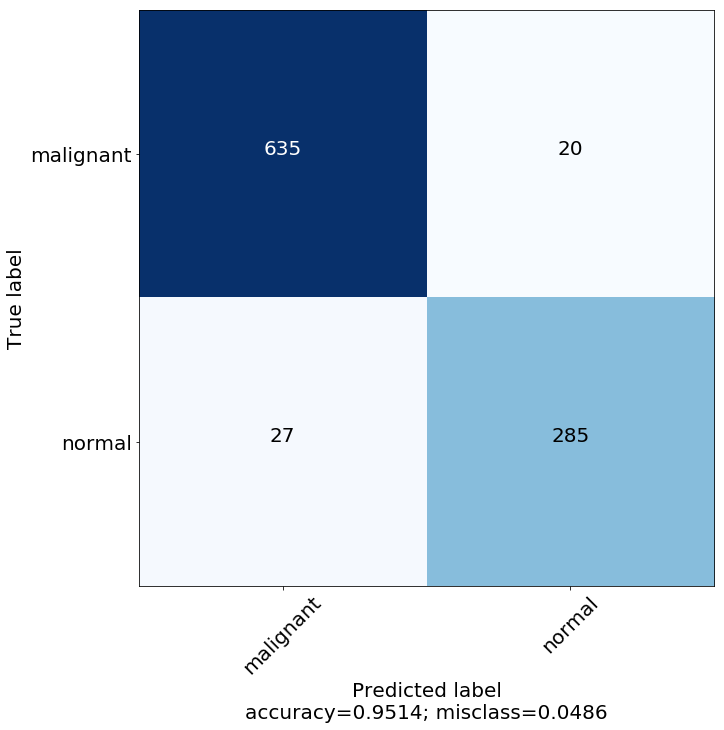

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[635  20]
 [ 27 285]]
              precision    recall  f1-score   support

   malignant       0.96      0.97      0.96       655
      normal       0.93      0.91      0.92       312

   micro avg       0.95      0.95      0.95       967
   macro avg       0.95      0.94      0.94       967
weighted avg       0.95      0.95      0.95       967



In [22]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  95.9214501510574
Specificity :  93.44262295081968


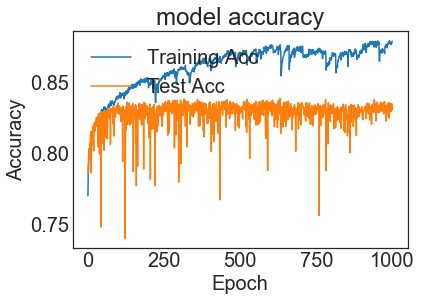

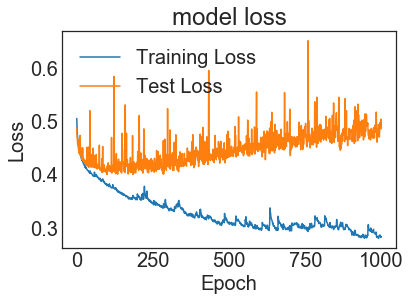

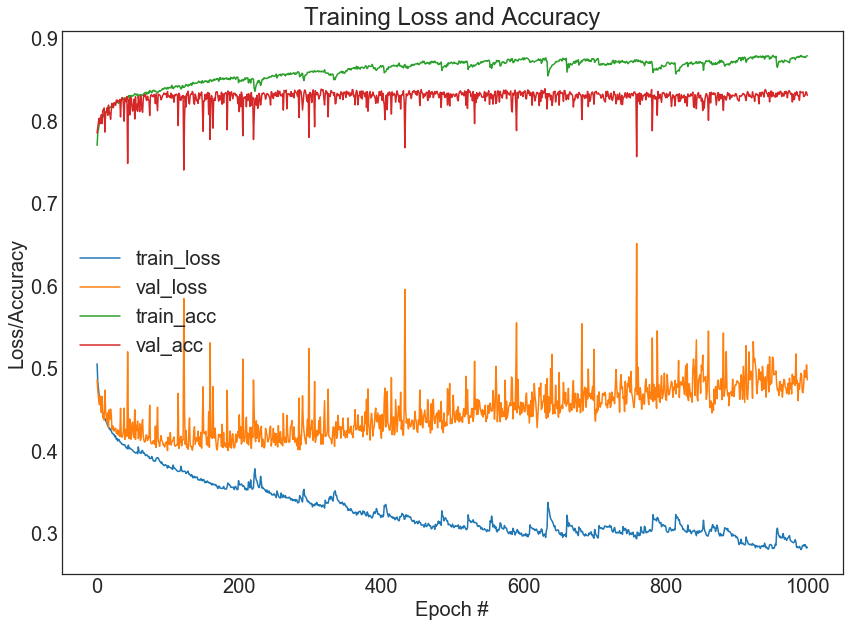

In [23]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure(figsize=(14,10))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [24]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 48us/step
Precision =  0.9512166309162187
Recall =  0.9513960703205792
f1_score =  0.951249526830925


In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.94146359365825


In [26]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

Sample count: 967
No of errors = 47/967
